# 矢量化加速
如下代码比较了一下用`loop`循环和使用内置重载运算符之间的运算效率区别
显然，内置更优。

In [45]:
%matplotlib inline
import math
import time 
import numpy as np
import torch
from d2l import torch as d2l

In [21]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [22]:
class Timer: #@save
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        self.tik = time.time()
    
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [23]:
c = torch.zeros(n)
timer = Timer()

for i in range(n):
    c[i] = a[i] + b[i]

f'{timer.stop():.5f} sec with python loop'

'0.03394 sec with python loop'

In [24]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec with overloaded operator `+`'

'0.00012 sec with overloaded operator `+`'

# 正态分布和平方损失

In [25]:
def normal(x, mu, sigma):
    """
    x is input variable
    mu is average
    sigma is 标准差
    return final value
    """
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

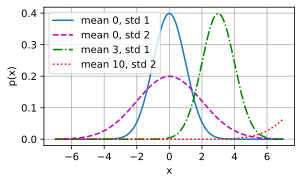

In [26]:
# visualize
x = np.arange(-7, 7, 0.01) # [start, end] step = 0.01

params = [(0, 1), (0, 2), (3, 1), (10,2)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5), legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])


# Start from ZERO

In [27]:
%matplotlib inline
import random

下面人工生成一个带有噪声的数据集，然后使用线性回归恢复其参数

In [28]:
def synthetic_data(w, b, num_examples): #@save
    """
    Generate `y = Xw + b + error`
    """
    X = torch.normal(0, 1, size = (num_examples, len(w))) # (mean, std, (row, col(row, col)(row, col)(row, col)(row, col)(row, col)(row, col)(row, col)(row, col)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [29]:
# help(torch.normal)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.3191, 2.2633]) 
label: tensor([-0.8644])


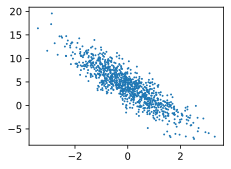

In [30]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

# 训练模型
## 1 读取数据
下面给出了一个比较简单的数据读取方式

In [31]:
def data_iter(batch_size, features, labels):
    """
    Good for learning but bad for training.
    """
    num_examples = len(features)
    indices = list(range(num_examples)) # generate a indices from 0 to num_examples
    random.shuffle(indices) # shuffle the list of indices

    # read data with random batch
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]
        )
        # batch_indices is a tensor, each time read a batch size data
        yield features[batch_indices], labels[batch_indices]

In [32]:
# Let's try for `data_iter`
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.0912, -0.1185],
        [-1.9813, -1.0946],
        [-0.3037, -1.0024],
        [ 0.2388,  0.1736],
        [-1.1334,  0.3635],
        [-0.2916, -0.5946],
        [-0.7734,  0.6264],
        [ 0.7125, -1.0259],
        [ 0.3763,  2.0583],
        [-1.3479, -0.2136]]) 
 tensor([[ 4.4036],
        [ 3.9587],
        [ 6.9802],
        [ 4.0749],
        [ 0.6841],
        [ 5.6446],
        [ 0.5305],
        [ 9.1102],
        [-2.0384],
        [ 2.2283]])


## 2 初始化模型参数

In [36]:
# randomly with gasi distribution
w = torch.normal(0, 1, size = (2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

# 3 定义模型

In [37]:
def linreg(X, w, b): #@save
    """
    Linear regression
    """
    return torch.matmul(X, w) + b

## 4 定义损失函数

In [38]:
def squared_loss(y_hat, y):
    """
    squared_loss = (y-y_hat)**2
    """
    return (y_hat - y.reshape(y_hat.shape))**2 / 2 # reshape for alignment

## 5 定义优化算法

In [39]:
def sgd(params, lr, batch_size): #@save
    """Small batch size stochastic gradient descent"""
    # params is a list of parameter that i want to excute gradient descent. This contest, weights and biases
    with torch.no_grad():
        # disable gradient tracking.
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

- `param.grad.zero_()` means everytime we will calculate a new gradient rather than add them up.
Sometimes accumulating gradients are useful, but here not.
- `with torch.no_grad()` here is a **context manager**, meaning that in `with` block we will have the arribute(or something) of no_grad().


## 6 训练
深度学习的训练过程基本都如下，着重理解！
1. 每次迭代，读取一小批量的训练样本
2. 通过模型来获取一组预测
3. 计算预测和真实值之间的损失
4. 开始反向传播，计算梯度
5. 最后使用优化算法sgd来更新模型参数。

In [40]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # net(X, w, b) predicate a y_hat
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041534
epoch 2, loss 0.000130
epoch 3, loss 0.000047


# 线性回归的简洁实现

In [41]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [42]:
from torch.utils import data
def load_array(data_arrays, batch_size, is_train = True): #@save
    """一个pytorch数据迭代器"""
    # is_train 表示是否希望数据迭代器对象在每个迭代周期内打乱数据
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle = is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [44]:
next(iter(data_iter))

[tensor([[-0.7804, -0.5044],
         [ 0.5663, -0.9863],
         [-1.0254,  0.1202],
         [-0.4276, -0.4741],
         [ 0.3769, -1.6798],
         [-0.2747,  0.1486],
         [ 0.0094, -0.3901],
         [-0.2110,  1.1837],
         [ 0.8292,  0.0036],
         [ 0.6034,  0.7639]]),
 tensor([[ 4.3584],
         [ 8.6883],
         [ 1.7428],
         [ 4.9505],
         [10.6745],
         [ 3.1114],
         [ 5.5441],
         [-0.2591],
         [ 5.8374],
         [ 2.8095]])]

In [51]:
# define model
from torch import nn

net = nn.Sequential(nn.Linear(2, 1)) 
# parameter 1 indicate input shape, parameter 2 indicate output shape
# and now net is our model

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
# access parameter of the layer directly by `wight.data` and `bias.data`
# use normal or fill to change parameter

loss = nn.MSELoss()
# squared loss

trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# choose the optimer as SGD, applying to parameters of the net with learning rate at 0.03


In [52]:
# Start trianing

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad() # clear gradients
        l.backward() # get gradient
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')


epoch 1, loss 0.000167
epoch 2, loss 0.000102
epoch 3, loss 0.000102


In [53]:
# get training results
w = net[0].weight.data
print('w error: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b error: ', true_b - b)

w error:  tensor([ 0.0005, -0.0005])
b error:  tensor([-0.0003])
